<h1>  Project of DDML </h1>

<h3>Author :</h3>
    <ul>
    <li> 
    Thibault POUX
    </li> 
    <li> 
    Pablo García
    </li> 
    <li> 
    Nabil Kaci 
    </li> 
    </ul>

<style>
.container {
    display: flex;
    flex-wrap: wrap;
    justify-content: center;
}

.image-group {
    display: flex;
    flex-direction: row;
    align-items: center;
    margin-bottom: 20px;
}

.image-box img {
    width: 300px; /* Adjust the width as needed */
    height: 300px; /* Adjust the height as needed */
    object-fit: cover;
}

.image-box img {
    max-width: 100%;
    height: auto;
}

.summary {
    margin-top: 20px;
}



.summary li {
    margin-bottom: 10px;
}
</style>

<div class="container">
    <div class="title">
        <h2>MRI Images of brain:</h2>
    </div>
    <div class="image-group">
        <div class="image-box">
            <img src="Dataset\no\no_3.jpg" alt="Image 1">
        </div>
        <div class="image-box">
            <img src="Dataset\no\no_78.jpg" alt="Image 2">
        </div>
    </div>
</div>

<div class="container">
    <div class="title">
        <h2>MRI Images for brain with a tumor:</h2>
    </div>
    <div class="image-group">
        <div class="image-box">
            <img src="Dataset\yes\yes_2.jpg" alt="Image 3">
        </div>
        <div class="image-box">
            <img src="Dataset\yes\yes_12.jpg" alt="Image 4">
        </div>
    </div>
</div>


<div class="summary">
    <h2>Summary</h2>
    <ul>
        <li>Number of cancer images: 155</li>
        <li>Number of non-cancer images: 98</li>
        <li>Link to dataset page: <a href="https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection">Kaggle.com</a></li>
    </ul>
</div>

In [1]:

#all import 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import time

import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate


#homemade package
from codigo.prep_data import data_proccesing
from codigo.prep_data import data_preProcessing
from codigo import models

# preporcessing the data if needed
data_preProcessing.run()

#import the data
X_flatten, Y_flatten = data_proccesing.load_data_flatten()




Quadratic Model

In [22]:
# Variables
r_state = [914, 895, 365, 264, 59, 500, 129]
pourcentage_of_test_data = 0.33

/home/chatarra/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables ar

Average of the different models, for 7 different test, with 33.0% of the data used the test set.
+---------------------------------+------------+------------------+---------------+-------------------+
| Model                           |   F1 Score | False negative   |   Time to fit |   Time to predict |
+=================================+============+==================+===============+===================+
| Quadratic Discriminant Analysis |       0.55 | 32.65%           |   0.681522    |         0.0353347 |
+---------------------------------+------------+------------------+---------------+-------------------+
| K-Nearest Neighbors             |       0.61 | 30.95%           |   0.000892707 |         0.039314  |
+---------------------------------+------------+------------------+---------------+-------------------+
| Multi-Layer Perceptron          |       0.7  | 15.65%           |   4.6825      |         0.010269  |
+---------------------------------+------------+------------------+----

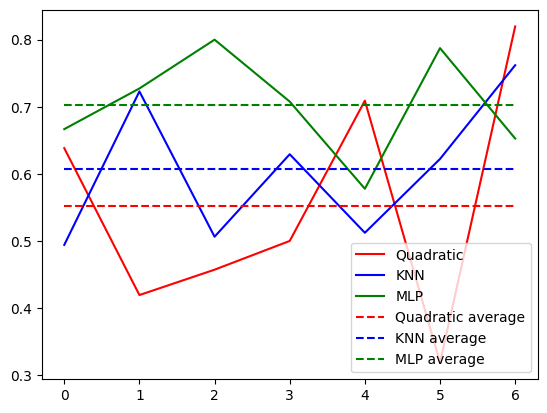

In [23]:
# specified all the models
reg_Quadra = QuadraticDiscriminantAnalysis()
reg_KNN = KNeighborsClassifier(n_neighbors=3)
reg_MLP = MLPClassifier(max_iter=10000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 5))

pretty_Names = {'quadra':'Quadratic Discriminant Analysis', 'knn':'K-Nearest Neighbors', 'mlp':'Multi-Layer Perceptron'}
data = {'quadra':{}, 'knn':{}, 'mlp':{}}
for key in data.keys():
    data[key]['f1'] = []
    data[key]['false_negatif'] = []
    data[key]['time_fit'] = 0
    data[key]['time_predict'] = 0

for int_state in r_state:

    # make the sample with ouldout
    X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, Y_flatten, test_size=pourcentage_of_test_data, random_state=int_state)

    for reg, name in zip([reg_Quadra, reg_KNN, reg_MLP], data.keys()): #loop over the models
        start_time = time.time()
        reg = reg.fit(X_train, Y_train)
        end_fit = time.time()
        result = reg.predict(X_test)
        end_predict = time.time()
        
        # save results
        data[name]['f1'].append(f1_score(Y_test, result))
        data[name]['false_negatif'].append(confusion_matrix(Y_test, result).ravel()[2])
        data[name]['time_fit'] += end_fit - start_time
        data[name]['time_predict'] += end_predict - end_fit

# part to display the results

# print the results in a table
output_data = []
for key in data.keys():
    name = pretty_Names.get(key)
    f1 = np.mean(data[key]['f1']).round(2)
    f_neg = str((np.mean(data[key]['false_negatif'])/len(Y_test)*100).round(2)) + '%'
    time_fit = (data[key]['time_fit']/len(r_state))
    time_predict = (data[key]['time_predict']/len(r_state))
    output_data.append([name, f1, f_neg, time_fit, time_predict])
    
    
print(f"Average of the different models, for {len(r_state)} different test, with {pourcentage_of_test_data*100}% of the data used the test set.") 

print(tabulate(output_data, headers=['Model', 'F1 Score', 'False negative', 'Time to fit', 'Time to predict'], tablefmt='grid'))


# plot a graph of the score for each model and for each iterration with a other curve for the average
plt.plot(data['quadra']['f1'], label='Quadratic', color='red')
plt.plot(data['knn']['f1'], label='KNN', color='blue')
plt.plot(data['mlp']['f1'], label='MLP', color='green')
plt.plot([sum(data['quadra']['f1'])/len(data['quadra']['f1'])]*len(data['quadra']['f1']), label='Quadratic average',   color='red', linestyle='--')
plt.plot([sum(data['knn']['f1'])/len(data['knn']['f1'])]*len(data['knn']['f1']), label='KNN average', color='blue', linestyle='--')
plt.plot([sum(data['mlp']['f1'])/len(data['mlp']['f1'])]*len(data['mlp']['f1']), label='MLP average', color='green', linestyle='--')
plt.legend()
plt.show()


<h2>Test for several neighbors in KNN, from 1 to 25.</h2>

In [2]:
# getting all the data for the KNN model
array_numnber_of_neighboor = [i for i in range(1, 26, 1)]
data = models.KNN_range((X_flatten, Y_flatten), array_numnber_of_neighboor, size_sample=0.2)


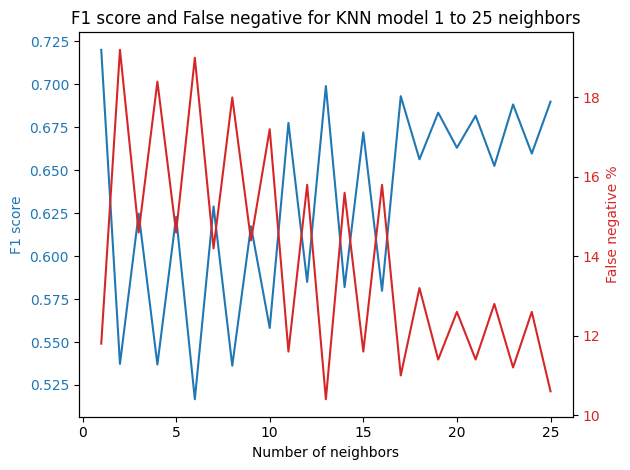

In [3]:
# ploting the results to annlaysis the best number of neighbors for the KNN model

fig, ax1 = plt.subplots()

# Plot F1 score on the first subplot
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('F1 score', color='tab:blue')
ax1.plot(array_numnber_of_neighboor, data['f1'], color='tab:blue', label='F1 score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('False negative %', color='tab:red')
ax2.plot(array_numnber_of_neighboor, data['fn'], color='tab:red', label='False negative')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('F1 score and False negative for KNN model 1 to 25 neighbors')
fig.tight_layout() 
plt.show()

<h1>KNN Model Evaluation</h1>
<p>I can see that the number of neighbors that gives the best result is about 20 (it depends on the seeds, but we can say 21). This value is the best because it maximizes the F1 score while also minimizing the false negative rate. </p>
<p>We are choosing 21 over 25 even though the results are similar because with fewer neighbors the algorithm is more efficient.</p>

<p>Best value of K: 21</p>

<h2>MLP</h2>

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Supongamos que X_flatten y Y_flatten son tus datos
# X_flatten es una matriz de características y Y_flatten son las etiquetas

# Primero dividimos los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_flatten, Y_flatten, test_size=0.2, random_state=59)

# Definimos las listas para almacenar los resultados
neurons_range = range(1, 16)
accuracies = np.zeros((len(neurons_range), len(neurons_range)))
f1_scores = np.zeros((len(neurons_range), len(neurons_range)))
falseNegatives = np.zeros((len(neurons_range), len(neurons_range)))

# Entrenamos varios MLP con diferentes configuraciones
for i, neurons1 in enumerate(neurons_range):
    for j, neurons2 in enumerate(neurons_range):
        mlp = MLPClassifier(max_iter=10000, hidden_layer_sizes=(neurons1,neurons2) , learning_rate_init=0.0001, solver='lbfgs', alpha=1e-5,random_state=59)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracies[i, j] = acc
        f1_scores[i, j] = f1
        falseNegatives[i,j]= confusion_matrix(y_test, y_pred).ravel()[2]
        


/home/chatarra/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/chatarra/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_

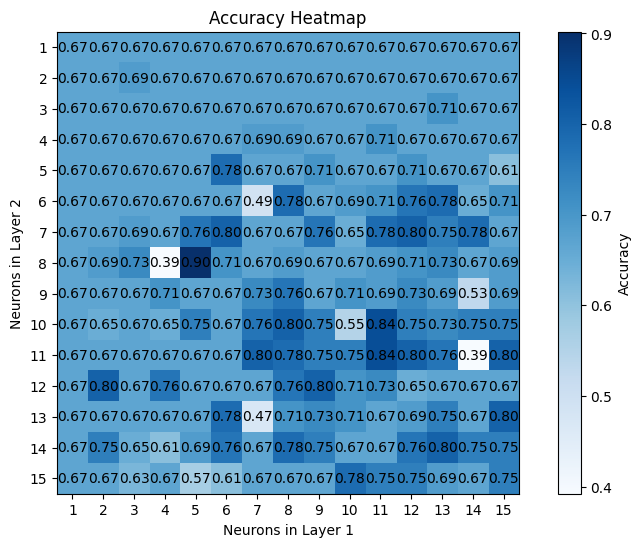

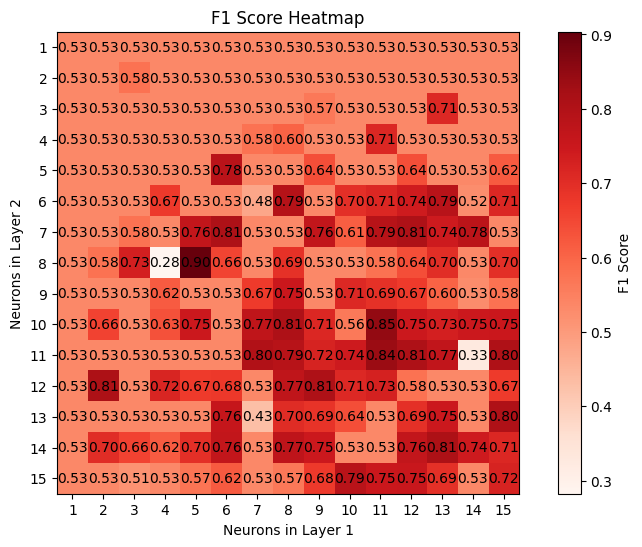

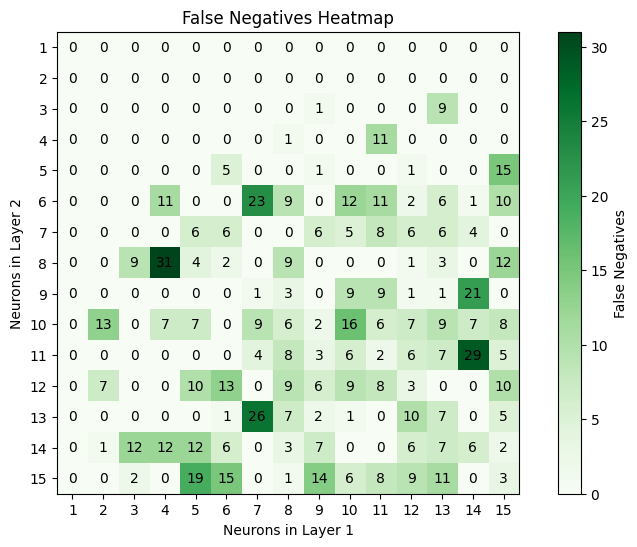

In [27]:
# Plotting accuracy heatmap with annotations
plt.figure(figsize=(10, 6))
plt.imshow(accuracies, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Accuracy Heatmap')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('Neurons in Layer 2')
plt.colorbar(label='Accuracy')
plt.xticks(np.arange(len(neurons_range)), neurons_range)
plt.yticks(np.arange(len(neurons_range)), neurons_range)
for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        plt.text(j, i, f'{accuracies[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# Plotting F1 score heatmap with annotations
plt.figure(figsize=(10, 6))
plt.imshow(f1_scores, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('F1 Score Heatmap')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('Neurons in Layer 2')
plt.colorbar(label='F1 Score')
plt.xticks(np.arange(len(neurons_range)), neurons_range)
plt.yticks(np.arange(len(neurons_range)), neurons_range)
for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        plt.text(j, i, f'{f1_scores[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# Plotting false negatives heatmap
plt.figure(figsize=(10, 6))
plt.imshow(falseNegatives, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('False Negatives Heatmap')
plt.xlabel('Neurons in Layer 1')
plt.ylabel('Neurons in Layer 2')
plt.colorbar(label='False Negatives')
plt.xticks(np.arange(len(neurons_range)), neurons_range)
plt.yticks(np.arange(len(neurons_range)), neurons_range)
for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        plt.text(j, i, f'{falseNegatives[i, j]:.0f}', ha='center', va='center', color='black')
plt.show()

<h2>CNN </h2>

In [78]:
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
#homemade package
from codigo.prep_data import data_proccesing
from codigo.prep_data import data_preProcessing

# preporcessing the data if needed
data_preProcessing.run()

#import the data
X_flatten, Y_flatten = data_proccesing.load_data()

X_train, X_test, y_train, y_test = train_test_split(X_flatten, Y_flatten, test_size=0.2)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [79]:
#Creamos el modelo
model = Sequential()
model.add(Conv2D(32,(3,3),activation= 'relu', input_shape =(128, 128, 3) ))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3),activation= 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(65, activation='relu'))
model.add(Dense(1, activation= 'sigmoid'))


# Print model summary
model.summary()


/home/chatarra/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 65)             │     1,872,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,882,275 (7.18 MB)

 Trainable params: 1,882,275 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Assuming y_pred and y_true are numpy arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (202, 128, 128, 3)
Shape of X_test: (51, 128, 128, 3)
Shape of y_train: (202, 1)
Shape of y_test: (51, 1)


In [82]:
#Compile the model
f1 = F1Score(average=None, threshold=None, name="f1_score", dtype=None)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy',f1])

model.fit(X_train,y_train, epochs= 10, batch_size=64)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.7249 - f1_score: 0.7757 - loss: 0.5518
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.8981 - f1_score: 0.7528 - loss: 0.3672
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.8886 - f1_score: 0.7838 - loss: 0.2638
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.9200 - f1_score: 0.7679 - loss: 0.1703
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.9481 - f1_score: 0.7817 - loss: 0.1074
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9694 - f1_score: 0.7762 - loss: 0.0649
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 1.0000 - f1_score: 0.7702 - loss: 0.0207
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.9954 - f1_score: 0.8113 - loss: 0.0071
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 1.0000 - f1_score: 0.7948 - loss: 7.7888e-04
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 1.0000

In [83]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7964 - f1_score: 0.7877 - loss: 1.7907 


[1.785954236984253, 0.8039215803146362, 0.7733332514762878]